In [1]:
import sys
sys.path.insert(0, "/home/szhydkov/Documents/mattei peer review/extedned_peer_selection/peerselect")
print(sys.path)

['/home/szhydkov/Documents/mattei peer review/extedned_peer_selection/peerselect', '', '/home/szhydkov/anaconda3/lib/python36.zip', '/home/szhydkov/anaconda3/lib/python3.6', '/home/szhydkov/anaconda3/lib/python3.6/lib-dynload', '/home/szhydkov/anaconda3/lib/python3.6/site-packages', '/home/szhydkov/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/home/szhydkov/.ipython']


In [2]:
### Standard Magic and startup initializers.

import math
import csv
import numpy as np
import random
import itertools
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from collections import Counter

from peerselect import impartial
from peerselect import profile_generator

%matplotlib inline
matplotlib.style.use('seaborn-whitegrid')

font = {'size'   : 14}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3)
np.set_printoptions(threshold=10)
#np.set_printoptions(threshold=np.inf)

In [6]:
# Theoretical estimates of expected size and expected accuracy (recall) of peer nomination
# from julia.api import Julia
# jl = Julia(compiled_modules=False)
import julia
jl = julia.Julia(compiled_modules=False)
jl.include("funs.jl")

/home/szhydkov/anaconda3/lib/python3.6/site-packages/julia/core.py:689: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,


<PyCall.jlwrap estimate_eps>

In [7]:
jl.estimate_eps(130, 10, 30)

/home/szhydkov/anaconda3/lib/python3.6/site-packages/julia/core.py:689: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,


-0.0015868684682767158

In [16]:
_DEBUG = False

#random.seed(15)

class Impartial:
    VANILLA = "Vanilla"
    EXACT = "ExactDollarPartition"
    PARTITION = "Partition"
    DPR = "DollarPartitionRaffle"
    CREDIABLE = "CredibleSubset"
    RAFFLE = "DollarRaffle"
    NOMINATION = "PeerNomination"
    ALL = (VANILLA, EXACT, PARTITION, RAFFLE, CREDIABLE, DPR, NOMINATION)

s = 50
test_n = [120]
test_k = [20, 25, 30]
test_m = [9]
test_l = [5]
test_p = [0.1, 0.25, ]

# Map for all Results.
v_results = {}
gt_results = {}
pn_sizes = {}  #track output size of peer nomination
for n,k,m,l,p in itertools.product(test_n, test_k, test_m, test_l, test_p):
    agents = np.arange(0, n)
    for c_sample in range(s):
        # Generate a profile and clustering
        profile = profile_generator.generate_mallows_mixture_profile(agents, agents, [1.0], [agents], [p])
        clustering = impartial.even_partition_order(sorted(agents, key=lambda j: random.random()), l)
        
        # Uncomment one:
        #TODO: check to see how many reviews each person is getting -- is it always off?
        # Borda -- need to start at 1 to distinguish from non-review in the score matrix
        scores = np.arange(m, 0, -1)
#         print(scores)
        #Lexicographic
        #scores = [pow(n, i) for i in np.arange(m, 0, -1)]
        
        # Generate an m-regular assignment
        m_assignment = profile_generator.generate_approx_m_regular_assignment(agents, m, clustering, randomize=False)
#         print(m_assignment[1])
        
        m_matrix = np.zeros((n,n))
        for i in agents:
            for j in m_assignment[i]:
                m_matrix[i, j] = 1
        
#         print(len([x for x in m_matrix[1] if x!=0]))
        score_matrix = profile_generator.strict_m_score_matrix(profile, m_assignment, scores)
#         print([len([x for x in score_matrix[i,:].tolist() if x!=0]) for i in agents])
#         print([len([x for x in score_matrix[:,i].tolist() if x!=0]) for i in agents])
#         print(score_matrix[:,110].tolist())

        

        #Compute Target Set.
        target_set = impartial.vanilla(score_matrix, k)
        
        # Capture the winning sets
        ws = {}
        # Let everyone else have the same size set so they are all compareable.
        vs = [i for i,j in target_set]
        ws[Impartial.VANILLA] = vs
        
        # Set all sizes to be the same.
        ws[Impartial.EXACT] = impartial.exact_dollar_partition_explicit(score_matrix, k, clustering, normalize=True)
        ws[Impartial.PARTITION] = impartial.partition_explicit(score_matrix, k, clustering, normalize=False)
        
        ws[Impartial.CREDIABLE] = impartial.credible_subset(score_matrix, k, m, normalize=False)
        ws[Impartial.DPR] = impartial.dollar_raffle_explicit(score_matrix, k, clustering, normalize=True)
        #Call Raffle and have everyone in a cluster by themselves = Dollar.
        ws[Impartial.RAFFLE] = impartial.dollar_raffle(score_matrix, k, n, randomize=True, normalize=True)
        
        # See if peer nomination works..
        ws[Impartial.NOMINATION] = impartial.peer_nomination_lottery(score_matrix, k, jl.estimate_eps(n, m, k))
#         print(len(ws[Impartial.NOMINATION]))
        
        for x in Impartial.ALL:
            key = (n, k, m, l, p, s, x)
#             if x == Impartial.NOMINATION:
#                 pn_sizes[key] = pn_sizes.get(key, []) + [len(set(ws[x]))]
            v_results[key] = v_results.get(key, []) + [len(set(vs) & set(ws[x]))]
            gt_results[key] = gt_results.get(key, []) + [len(set(np.arange(0, k)) & set(ws[x]))]
            #if x == Impartial.VANILLA:
            #    print(ws[x])
            
        key = (n, k, m, l, p)
        pn_sizes[key] = pn_sizes.get(key, []) + [len(set(ws[x]))]
        
    print("k = " + str(k) + ", actual average size = " + str(np.mean(pn_sizes[key])))
    print("Finished: " + ",".join([str(x) for x in [n, k, m, l, p, s]]))
    
v_df = pd.DataFrame(v_results)
v_df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']

gt_df = pd.DataFrame(gt_results)
gt_df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']

/home/szhydkov/anaconda3/lib/python3.6/site-packages/julia/core.py:689: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,


k = 15, actual average size = 15.82
Finished: 120,15,8,5,0.0,50
k = 15, actual average size = 15.46
Finished: 120,15,9,5,0.0,50
k = 15, actual average size = 15.26
Finished: 120,15,10,5,0.0,50
k = 15, actual average size = 15.5
Finished: 120,15,11,5,0.0,50
k = 20, actual average size = 20.4
Finished: 120,20,8,5,0.0,50
k = 20, actual average size = 19.94
Finished: 120,20,9,5,0.0,50
k = 20, actual average size = 19.96
Finished: 120,20,10,5,0.0,50
k = 20, actual average size = 20.38
Finished: 120,20,11,5,0.0,50
k = 25, actual average size = 25.84
Finished: 120,25,8,5,0.0,50
k = 25, actual average size = 25.02
Finished: 120,25,9,5,0.0,50
k = 25, actual average size = 24.9
Finished: 120,25,10,5,0.0,50
k = 25, actual average size = 24.82
Finished: 120,25,11,5,0.0,50
k = 30, actual average size = 30.16
Finished: 120,30,8,5,0.0,50
k = 30, actual average size = 30.26
Finished: 120,30,9,5,0.0,50
k = 30, actual average size = 30.66
Finished: 120,30,10,5,0.0,50
k = 30, actual average size = 29.9
F

In [10]:
for key in pn_sizes.keys():
    print(key)
    print(np.mean(pn_sizes[key]))

(120, 15, 8, 5, 0.5)
15.84
(120, 15, 9, 5, 0.5)
15.66
(120, 15, 10, 5, 0.5)
15.12
(120, 15, 11, 5, 0.5)
15.18
(120, 20, 8, 5, 0.5)
20.46
(120, 20, 9, 5, 0.5)
20.04
(120, 20, 10, 5, 0.5)
19.86
(120, 20, 11, 5, 0.5)
20.44
(120, 25, 8, 5, 0.5)
25.68
(120, 25, 9, 5, 0.5)
25.1
(120, 25, 10, 5, 0.5)
25.1
(120, 25, 11, 5, 0.5)
25.4
(120, 30, 8, 5, 0.5)
30.42
(120, 30, 9, 5, 0.5)
30.16
(120, 30, 10, 5, 0.5)
29.8
(120, 30, 11, 5, 0.5)
30.14


		Approximate Vanilla Ordering
		 MEAN:
algo                Vanilla  ExactDollarPartition  Partition  PercentChange
n   k  m  l p   s                                                          
120 15 10 5 0.0 50    13.20                 11.94      12.02      -0.665557
    20 10 5 0.0 50    17.76                 16.22      15.92       1.884422
    25 10 5 0.0 50    22.68                 21.06      20.74       1.542912
    30 10 5 0.0 50    27.36                 25.66      25.18       1.906275
		 STD:
algo                 Vanilla  ExactDollarPartition  Partition  PercentChange
n   k  m  l p   s                                                           
120 15 10 5 0.0 50  0.808122              1.268295   1.316923      -3.692557
    20 10 5 0.0 50  0.893514              1.183043   1.175255       0.662698
    25 10 5 0.0 50  0.819158              1.268295   1.396935      -9.208781
    30 10 5 0.0 50  1.257792              1.271509   1.649861     -22.932360
		 MIN:
algo                Vanill

/home/szhydkov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/szhydkov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


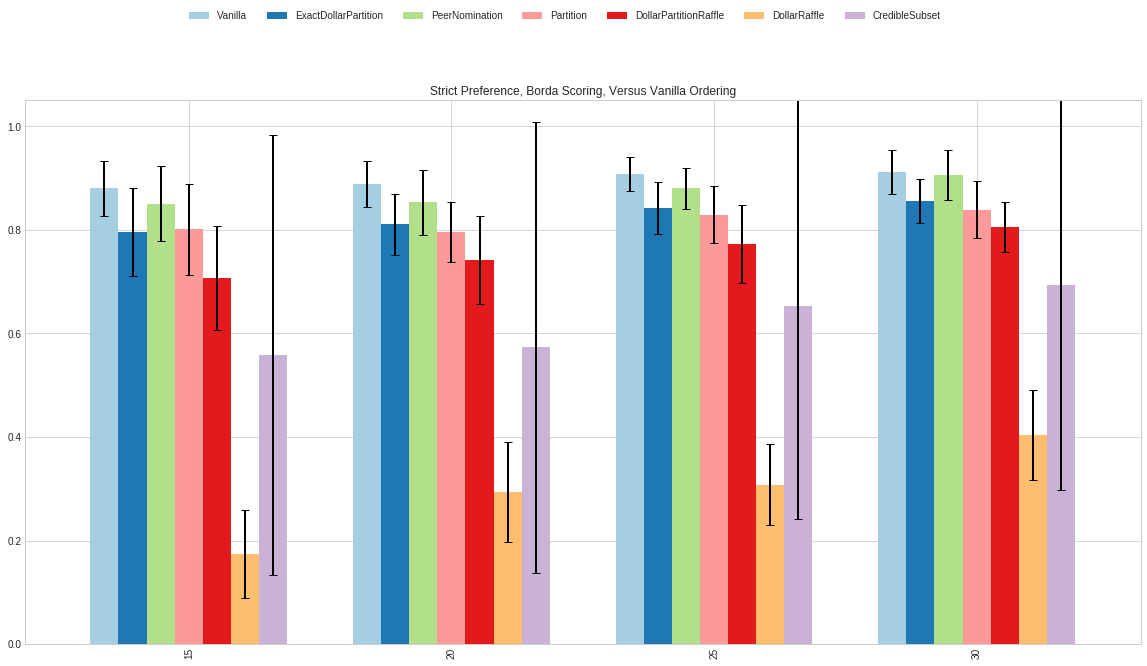

In [21]:
#
# Takes a slice of the array and generates the graphs etc.
#
def make_output(df, test, labels):
    means = df.loc[:, test].mean().unstack()
    errors = df.loc[:, test].std().unstack()
    mins = df.loc[:, test].min().unstack()
    # print(means)
    # print(errors)

    print("\t\tApproximate Vanilla Ordering")
    means = means[['Vanilla','ExactDollarPartition', "PeerNomination", 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
    errors = errors[['Vanilla','ExactDollarPartition', "PeerNomination", 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
    
    means['PercentChange'] = (means.ExactDollarPartition - means.Partition) / means.Partition * 100.
    errors['PercentChange'] = (errors.ExactDollarPartition - errors.Partition) / errors.Partition * 100.
    mins['PercentChange'] = (mins.ExactDollarPartition - mins.Partition) / mins.Partition * 100.
    print("\t\t MEAN:\n" + str(means[['Vanilla','ExactDollarPartition', 'Partition', 'PercentChange']]))
    print("\t\t STD:\n" + str(errors[['Vanilla','ExactDollarPartition', 'Partition', 'PercentChange']]))
    print("\t\t MIN:\n" + str(mins[['Vanilla','ExactDollarPartition', 'Partition', 'PercentChange']]))
    del means['PercentChange']
    del errors['PercentChange']
    del mins['PercentChange']
    
    for index, row in means.iterrows():
        means.ix[index] = row / float(index[1])
    for index, row in errors.iterrows():
        errors.ix[index] = row / float(index[1])
    
    # print(errors)
    
    #Set colors..
    color_list = plt.cm.Paired(np.linspace(0, 1, 10))
    color_list = color_list[:7]
    #color_list = sns.color_palette("pastel", 6)
    means.plot(kind='bar', legend=False, yerr=errors.values.T, figsize=(20, 10), ylim=(0.0, 1.05), \
            color=color_list, error_kw={'ecolor':'Black', 'linewidth':2, 'capsize':4}, width=0.75)
    plt.title("Strict Preference, Borda Scoring, Versus Vanilla Ordering")
    plt.legend(bbox_to_anchor = (0,0.01,1,1), bbox_transform=plt.gcf().transFigure, loc='upper center', ncol=7, borderaxespad=0.)
    plt.gca().set_xticklabels(labels)
    plt.gca().set_xlabel("")
    plt.show()
make_output(gt_df, (120,slice(None),10,5,0.0,50), test_k)

In [18]:
(gt_df[(130,25,9,5,0.5,20)]/25).mean()

algo
Vanilla                  0.886
ExactDollarPartition     0.826
Partition                0.802
DollarRaffle             0.344
CredibleSubset           0.708
DollarPartitionRaffle    0.762
PeerNomination           0.832
dtype: float64

In [ ]:
a = np.array([[1, 2, 0, 0],
              [2, 1, 1, 1],
              [0, 0, 3, 0],
              [0, 0, 0, 4]])
    

In [ ]:
(a[0,:].nonzero()[0])

In [ ]:
from scipy import stats

# We assume that the score matrix is strict, i.e., there are no ties in the scores assigned.

def peer_nomination_lottery(score_matrix, k, epislon=0):
    winning_set = []
    n = score_matrix.shape[0]
    for a in range(score_matrix.shape[0]):
        print("agent",a)
        nomination_count = 0
        # Iterate over each column that has non_zero entry.
        for pool in (score_matrix[a,:].nonzero()[0]):
            # Compute the nominating fraction
            # m is the numner of non-zero entries in teh column
            m = np.count_nonzero(score_matrix[:,pool])
            nomination_fraction = (float(k) / float(n)) * m           
            print(nomination_fraction)
            print(score_matrix[:,pool])
            # ranks is densely packed and will have highest value at best scored agent.
            ranks = stats.rankdata(score_matrix[:,pool], method='dense').astype(int)
            print(ranks)
            max_rank = np.max(ranks)
            print("threshold", max_rank - np.floor(nomination_fraction))
            # The player needs to fall within ranks > max_rank - floor(nomination_quota)
            if ranks[a] > max_rank - np.floor(nomination_fraction):
                print("nominated @ 1")
                nomination_count += 1
            # Otherwise if it is in the border line rank then we nominate with the remainder.
            elif ranks[a] > (max_rank - np.floor(nomination_fraction) - 1):
                print("nominated @ remainder", nomination_fraction - np.floor(nomination_fraction))
                if np.random.uniform() < nomination_fraction - np.floor(nomination_fraction):
                    nomination_count += 1
        print("nomination_count", nomination_count)
        # If we are nominated by at least half the people who review us...
        if nomination_count >= np.floor(np.count_nonzero(score_matrix[a,:]) / 2.0):
            winning_set.append(a)
    return winning_set
        
            
                
            
            
        

peer_nomination_lottery(a, 2, 0.0)

In [ ]:
a[0].nonzero()

In [ ]:
a[:,1]

In [ ]:
np.floor(2.5)

In [ ]:
np.random.uniform()